In [1]:
PATH='/home/kirana/Documents/phd/experiment1_new/DNNREC_BookCrossing'
DATAPATH='/home/kirana/Documents/final_dissertation_final/experiments/datasets/bookcrossing'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import os
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import pickle
from sklearn import metrics

In [3]:
[dftrain,dfvalid,results_concat]=pickle.load(open(f'{DATAPATH}/df_side_cold_runother.pkl','rb'))

In [4]:
df=pd.concat([dftrain,dfvalid[dftrain.columns]],axis=0)

In [5]:
user_to_idx={j:i+1 for i, j in enumerate(df['userId'].unique())}
item_to_idx={j:i+1 for i,j in enumerate(df['itemId'].unique())}
idx_to_user={i+1:j for i, j in enumerate(df['userId'].unique())}
idx_to_item={i+1:j for i,j in enumerate(df['itemId'].unique())}

In [6]:
dftrain['user_idx']=[user_to_idx[i] for i in dftrain['userId']]
dftrain['item_idx']=[item_to_idx[i] for i in dftrain['itemId']]

In [7]:
dfvalid['user_idx']=[user_to_idx[i] for i in dfvalid['userId']]
dfvalid['item_idx']=[item_to_idx[i] for i in dfvalid['itemId']]

In [8]:
pickle.dump([df, dftrain,dfvalid,idx_to_user,idx_to_item,item_to_idx,user_to_idx],open(f'{DATAPATH}/reads.pkl','wb'))

### Dataset and DataLoader

In [9]:
class cfdata (torch.utils.data.dataset.Dataset):
    def __init__(self,dfX,dfY):
        self.dfX,self.dfY=dfX,dfY
        
    def __len__ (self):
        return self.dfX.shape[0]
    
    def __getitem__ (self, idx):
        return torch.LongTensor(self.dfX.iloc[idx].values),torch.FloatTensor([self.dfY.values[idx]])

In [10]:
dstrain=cfdata(dftrain[['user_idx','item_idx']],dftrain['rating'])
dsvalid=cfdata(dfvalid[['user_idx','item_idx']],dfvalid['rating'])

In [11]:
dftrain.shape

(390999, 18)

In [12]:
bs=64

In [13]:
dltrain=DataLoader(dstrain,bs,True)

In [14]:
dlvalid=DataLoader(dsvalid,bs,False)

In [15]:
len(user_to_idx),len(item_to_idx)

(77805, 185973)

In [16]:
len(dltrain)

6110

In [17]:
6110*64

391040

## Model Architecture

In [18]:
n_users=len(user_to_idx)
n_items=len(item_to_idx)
n_emb_user=50
n_emb_item=50
min_rating=min(dftrain['rating'])
max_rating=max(dftrain['rating'])
dropout_e=0.1

In [19]:
n_users

77805

In [20]:
class cf(nn.Module):    
    def __init__(self,n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,dropout_e=0.01):
        super().__init__()
        self.n_users,self.n_emb_user,self.n_emb_item,self.n_items,self.min_rating,self.max_rating=\
                    n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating
        self.dropout_e=dropout_e
        self.create_architecture()
        self.init_parameters()
        self.criterion=nn.MSELoss()
        
        
    def create_architecture(self):
        self.emb_user=nn.Embedding(self.n_users+1,self.n_emb_user)
        self.emb_item=nn.Embedding(self.n_items+1,self.n_emb_item)
        self.emb_dropout=nn.Dropout(self.dropout_e)
        self.ub=nn.Embedding(self.n_users+1,1)
        self.ib=nn.Embedding(self.n_items+1,1)

        self.sigmoid=nn.Sigmoid()
        
        
    def init_parameters(self):
        nn.init.kaiming_normal_(self.emb_user.weight.data)
        nn.init.kaiming_normal_(self.emb_item.weight.data)
        nn.init.kaiming_normal_(self.ub.weight.data)
        nn.init.kaiming_normal_(self.ib.weight.data)

       
    def forward (self,Xb,Yb):               
        users=self.emb_dropout(self.emb_user(Xb[:,0]))
        items=self.emb_dropout(self.emb_item(Xb[:,1]))
        users_bias=self.emb_dropout(self.ub(Xb[:,0]))
        items_bias=self.emb_dropout(self.ib(Xb[:,1]))

        out=(users*items).sum(1)+users_bias.squeeze()+items_bias.squeeze()
        out=self.sigmoid(out)
        preds=out*(self.max_rating-self.min_rating)+self.min_rating
        preds=preds.view(-1,1)
        loss=self.criterion(preds,Yb)
        return preds,loss

In [21]:
n_users

77805

In [22]:
cfobj=cf(n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,dropout_e)

In [23]:
cfobj

cf(
  (emb_user): Embedding(77806, 50)
  (emb_item): Embedding(185974, 50)
  (emb_dropout): Dropout(p=0.1)
  (ub): Embedding(77806, 1)
  (ib): Embedding(185974, 1)
  (sigmoid): Sigmoid()
  (criterion): MSELoss()
)

In [24]:
for Xb, Yb in dltrain:
    break

In [25]:
Xb.shape, Yb.shape

(torch.Size([64, 2]), torch.Size([64, 1]))

In [26]:
cfobj.forward(Xb,Yb)

(tensor([[4.8015],
         [1.2757],
         [1.1609],
         [6.4953],
         [1.5629],
         [9.5535],
         [9.9212],
         [3.3590],
         [3.1289],
         [3.9238],
         [5.0491],
         [7.5463],
         [2.0278],
         [4.0464],
         [3.2742],
         [8.1460],
         [8.3292],
         [4.1720],
         [1.2438],
         [7.2773],
         [6.6760],
         [1.5860],
         [7.8158],
         [7.7835],
         [5.3488],
         [3.8542],
         [7.1323],
         [9.7728],
         [9.5398],
         [2.6397],
         [3.4760],
         [7.5638],
         [5.6314],
         [8.9558],
         [6.7756],
         [4.6568],
         [8.0387],
         [2.6961],
         [5.8878],
         [2.1980],
         [9.9338],
         [3.4165],
         [9.7117],
         [4.9370],
         [8.8369],
         [1.3525],
         [2.6878],
         [7.6241],
         [7.6294],
         [5.7586],
         [9.9144],
         [1.7634],
         [1.

## Learner

In [27]:
class Learner():
    def __init__(self,model,optimizer,metric_fn,device,bptt=12,print_every=5,clip_val=None,\
                 cycle_mult=0,lr_decay=0.7,wd_mult=1.1,start_lr=2e-2, end_lr=5e-4,error_type="mse"):
        self.model,self.optimizer,self.metric_fn,self.device,self.print_every,self.bptt,self.losses,self.clip_val=\
            model,optimizer,metric_fn,device,print_every,bptt,[],clip_val
        self.n_epochs=1
        self.cycle_mult,self.lr_decay=cycle_mult,lr_decay
        self.wd_mult=wd_mult
        for param_group in self.optimizer.param_groups:
            self.start_lr=param_group['lr']
            self.start_wd=param_group['weight_decay']
        self.wd=self.start_wd
        self.lr=self.start_lr
        self.end_lr=end_lr
        self.n_epoch=0
        self.lrs=[1e-2,5e-3,1e-4,5e-4]
        self.preds,self.preds_valid,self.trainY,self.actual=[],[],[],[]
        self.ratio=self.end_lr/self.start_lr
        self.num_steps=self.cycle_mult
        self.reset_cycle=self.cycle_mult
        self.error_type=error_type
        self.scores=[]
        self.generate_scores=False
        
    def fit (self,Xb,Yb,mode_train=True):
        if mode_train:
            self.model.train()
        else:
            self.model.eval()
        
        #import pdb
        #pdb.set_trace()
        preds,loss=self.model(Xb,Yb)

     
        if mode_train:
            if 1==0:
                lr =self.lrs[torch.randint(0,4,(1,))]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        myloss=loss.item()
    
        
        with torch.no_grad():
            if self.error_type == "mse":
                acc=nn.L1Loss() (preds,Yb)
                myrmse=np.sqrt(myloss)
            else:
                acc=nn.MSELoss() (preds,Yb)
                myrmse=np.sqrt(acc.item())
            acc=acc.item()
                 
        if mode_train==False:
            if self.generate_scores:
                self.scores.append(preds.detach().cpu().numpy().flatten())
        del preds
        del loss
        
        if self.clip_val is not None:
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_val)
        
        return myloss, acc, myrmse
    
    def lr_find (self,start_lr,end_lr,iterator,n_batch):
        losses,lrs=[],[]
        ratio=end_lr/start_lr
        num_steps=n_batch
        lr=start_lr
        for i in range(num_steps):            
            lr=lr*(end_lr/start_lr)**(1/num_steps)
            lrs.append(lr)
        self.lrs=lrs
        self.run_epoch(iterator,mode_train=True,lrs=lrs)
    
    def run_epoch(self,iterator,mode_train,lrs=None):
        epoch_loss,epoch_acc,i,k=0,0,0,0
        epoch_rmse=0

        for Xb,Yb in iterator:
            Xb=Xb.to(self.device)
            Yb=Yb.to(self.device)
            
            if lrs is not None:
                lr=lrs[k]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr 
            
            loss,acc,myrmse=self.fit(Xb,Yb,mode_train)
            
            if lrs is not None:
                self.losses.append(loss)

            epoch_loss+=loss
            epoch_acc+=acc
            epoch_rmse+=myrmse
            
            k=k+1
            if k%self.print_every == 0:
                if k:
                    print (f'Batch:{k} {epoch_loss/(k)}  ')  
                    torch.cuda.empty_cache()

        epoch_loss=epoch_loss/len(iterator)
        epoch_acc=epoch_acc/len(iterator)
        epoch_rmse=epoch_rmse/len(iterator)
            
        return epoch_loss,epoch_acc,epoch_rmse
    
    def plot_lrs(self, n_roll=1,ylim=None,xlim=None):
        import seaborn as sns
        ax=sns.lineplot(x=self.lrs,y=pd.Series(self.losses).rolling(n_roll).mean())
        ax.set_xscale('log')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate')
        if ylim is not None:
            plt.ylim(ylim)
        if xlim is not None:
            plt.xlim(xlim)

     
    def run_epochs(self,dltrain,dlvalid,n_epochs=1):              
        for epoch in range(n_epochs):                
            loss,acc,rmse=self.run_epoch(dltrain,True)

            lossv,accv,rmsev=self.run_epoch(dlvalid,mode_train=False)
           
            if self.error_type=="mse":
                loss_mse=loss
                loss_rmse=rmse
                loss_mae=acc
                lossv_mse=lossv
                lossv_rmse=rmsev
                lossv_mae=accv
                
            else:
                loss_mse=acc
                loss_rmse=rmse
                loss_mae=loss
                lossv_mse=accv
                lossv_rmse=rmsev
                lossv_mae=lossv
            
            print (f'Epoch:{epoch} Learning rate {self.lr} Weight Decay {self.wd} Train Loss:{loss} \
                Valid Loss:{lossv} Train RMSE:{loss_rmse} Valid RMSE:{lossv_rmse} ')

              
         
     
            if self.cycle_mult:
                if self.n_epoch==self.reset_cycle:
                    self.lr=self.start_lr
                    self.wd=self.start_wd
                    self.reset_cycle*=self.cycle_mult
                    #reset_cycle=self.n_epoch+reset_cycle
                    self.n_epoch=0
                    self.ratio=self.end_lr/self.start_lr
                    self.num_steps=self.reset_cycle
                else:
                    #self.lr*=(self.lr_decay**self.n_epoch)  
                    #if self.n_epoch>1:
                    self.wd*=self.wd_mult
                    self.lr=self.lr*(self.end_lr/self.start_lr)**(1/self.num_steps)
                    self.n_epoch+=1
        

                
            for param_group in self.optimizer.param_groups:
                param_group['lr']=self.lr
                param_group['weight_decay']=self.wd
          
     

In [28]:
if 1==1:
    del cfobj
    torch.cuda.empty_cache()

In [29]:
device='cuda:1'

In [30]:
cfobj=cf(n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,dropout_e)

In [31]:
cfobj=cfobj.to(device)

In [32]:
cfobj

cf(
  (emb_user): Embedding(77806, 50)
  (emb_item): Embedding(185974, 50)
  (emb_dropout): Dropout(p=0.1)
  (ub): Embedding(77806, 1)
  (ib): Embedding(185974, 1)
  (sigmoid): Sigmoid()
  (criterion): MSELoss()
)

In [33]:
len(dltrain)

6110

In [34]:
wd=5e-5
optimizer=torch.optim.Adam(cfobj.parameters(),lr=1e-4,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(cfobj,optimizer,None,device,0,10000,0.25,cycle_mult=0)

In [36]:
learner.lr_find(1e-4,1e-1,dltrain,len(dltrain))

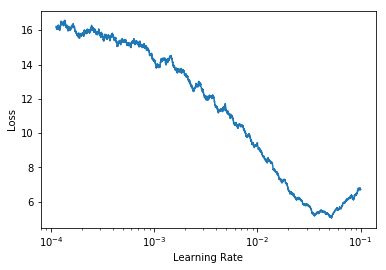

In [37]:
learner.plot_lrs(100)

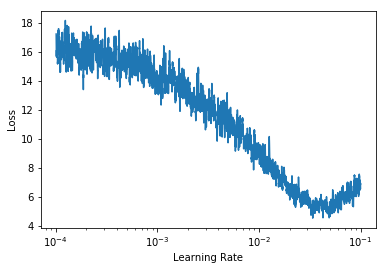

In [38]:
learner.plot_lrs(10)

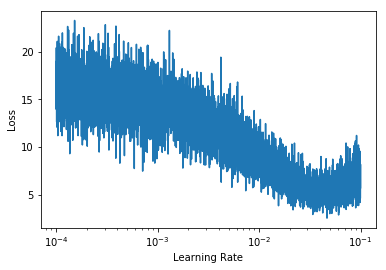

In [42]:
learner.plot_lrs(1)

In [43]:
del cfobj
torch.cuda.empty_cache()

NameError: name 'cfobj' is not defined

In [44]:
print (wd)

5e-05


In [45]:
cfobj=cf(n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,dropout_e)
cfobj=cfobj.to(device)

In [46]:
device

'cuda:1'

In [47]:
optimizer=torch.optim.Adam(cfobj.parameters(),lr=9e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(cfobj,optimizer,None,device,0,16000,0.25,cycle_mult=0,start_lr=1e-2,end_lr=3e-3,wd_mult=1.2)

In [48]:
learner.run_epochs(dltrain,dlvalid,2)

Epoch:0 Learning rate 0.009 Weight Decay 5e-05 Train Loss:5.000558435468158                 Valid Loss:3.6116743375515115 Train RMSE:2.1961711609828787 Valid RMSE:1.8803170489873018 
Epoch:1 Learning rate 0.009 Weight Decay 5e-05 Train Loss:3.2381463911646517                 Valid Loss:3.536161630764894 Train RMSE:1.7892008138504927 Valid RMSE:1.859509301334934 


In [49]:
for param_group in optimizer.param_groups:
    param_group['lr']=7e-3
learner.lr=7e-3

In [50]:
learner.run_epochs(dltrain,dlvalid,2)

Epoch:0 Learning rate 0.007 Weight Decay 5e-05 Train Loss:3.067610724350825                 Valid Loss:3.485388481277397 Train RMSE:1.7413805516825733 Valid RMSE:1.8453656686918267 
Epoch:1 Learning rate 0.007 Weight Decay 5e-05 Train Loss:3.0661746767655917                 Valid Loss:3.4919286530235896 Train RMSE:1.7403135046475402 Valid RMSE:1.8469457002624012 


In [52]:
for param_group in optimizer.param_groups:
    param_group['lr']=5e-3
    param_group['weight_decay']=7e-5
learner.lr=5e-3

In [53]:
learner.run_epochs(dltrain,dlvalid,2)

Epoch:0 Learning rate 0.005 Weight Decay 5e-05 Train Loss:3.031463120046107                 Valid Loss:3.493179710729905 Train RMSE:1.7305071564585686 Valid RMSE:1.8469076541601217 
Epoch:1 Learning rate 0.005 Weight Decay 5e-05 Train Loss:3.0445820565894857                 Valid Loss:3.4617538223380984 Train RMSE:1.7359672756589313 Valid RMSE:1.8384449456333443 


In [59]:
for param_group in optimizer.param_groups:
    param_group['lr']=3e-3
learner.lr=3e-3

In [60]:
learner.run_epochs(dltrain,dlvalid,2)

Epoch:0 Learning rate 0.003 Weight Decay 5e-05 Train Loss:2.7939745319455422                 Valid Loss:3.445212669637071 Train RMSE:1.6623839612390878 Valid RMSE:1.8337015198552684 
Epoch:1 Learning rate 0.003 Weight Decay 5e-05 Train Loss:2.8392410042633207                 Valid Loss:3.439087179825939 Train RMSE:1.6754063501782246 Valid RMSE:1.8319178023221427 


In [61]:
learner.generate_scores=True

In [62]:
learner.run_epoch(dlvalid,False)

(3.439087179825939, 1.4712304191432077, 1.8319178023221427)

In [66]:
dfvalid['pred_cf']=np.concatenate(learner.scores)#[dfvalid.shape[0]:]

In [67]:
np.sqrt(metrics.mean_squared_error(dfvalid['rating'],dfvalid['pred_cf']))

1.854213745296641

In [68]:
learner.generate_scores=False

In [69]:
def score_by_group (dfvalid,predVar,groupVar='cold_start_group',method='global_avg'):
    scores=[]
    mae_scores=[]
    rmse_scores=[]
    r2_scores=[]
    groups=dfvalid[groupVar].value_counts().index.tolist()
    for group in groups:
        df=dfvalid.loc[dfvalid[groupVar]==group]
        actual=df['rating']
        score=metrics.mean_squared_error(df['rating'],df[predVar])
        rmse_score=np.sqrt(metrics.mean_squared_error(df['rating'],df[predVar]))
        mae_score=metrics.mean_absolute_error(df['rating'],df[predVar])
        r2_score=metrics.r2_score(df['rating'],df[predVar])
        scores.append(score)
        mae_scores.append(mae_score)
        rmse_scores.append(rmse_score)
        r2_scores.append(r2_score)
    return pd.DataFrame({'method':method, 'mse':scores, 'rmse':rmse_scores, 'mae':mae_scores, 'r2_score':r2_scores, 'Cold Start Group':groups})

In [70]:
result_cf=pd.concat([score_by_group(dfvalid,'pred_cf','cold_start_group','cf'),score_by_group(dfvalid,'pred_cf','cold_start_bucket','cf'),\
score_by_group(dfvalid,'pred_cf','flag_train','cf')],axis=0)
result_cf

,method,mse,rmse,mae,r2_score,Cold Start Group
0,cf,2.863827,1.692284,1.338829,0.136905,No-cold-start
1,cf,2.998901,1.731733,1.361129,0.173919,Item-Cold_start
2,cf,5.224204,2.285652,1.922926,-0.527182,User-Cold-Start
3,cf,7.373656,2.715448,2.319444,-0.877088,User-Item-cold-start
0,cf,2.863827,1.692284,1.338829,0.136905,0
1,cf,4.177386,2.043865,1.641165,-0.157417,1
0,cf,3.438109,1.854214,1.471009,0.004667,0


In [71]:
results_concat

,method,mse,rmse,mae,r2_score,Cold Start Group
0,biasedmatrixfactorization,3.285500,1.812595,1.372624,0.009822,No-cold-start
1,biasedmatrixfactorization,2.638329,1.624293,1.218794,0.273242,Item-Cold_start
2,biasedmatrixfactorization,3.361617,1.833471,1.429907,0.017305,User-Cold-Start
3,biasedmatrixfactorization,3.988708,1.997175,1.612015,-0.015393,User-Item-cold-start
0,biasedmatrixfactorization,3.285500,1.812595,1.372624,0.009822,0
1,biasedmatrixfactorization,3.012811,1.735745,1.327987,0.165248,1
0,biasedmatrixfactorization,3.166282,1.779405,1.353109,0.083361,0
0,svdplusplus,2.738175,1.654743,1.290668,0.174774,No-cold-start
1,svdplusplus,2.830975,1.682550,1.303101,0.220176,Item-Cold_start
2,svdplusplus,3.284872,1.812422,1.440296,0.039739,User-Cold-Start


In [72]:
mtx_user_emb=cfobj.emb_user.weight.data.cpu().numpy()
mtx_item_emb=cfobj.emb_item.weight.data.cpu().numpy()

In [73]:
user_bias_emb=cfobj.ub.weight.data.cpu().numpy()
item_bias_emb=cfobj.ib.weight.data.cpu().numpy()

In [74]:
mtx_user_emb.shape, mtx_item_emb.shape, user_bias_emb.shape, item_bias_emb.shape

((77806, 50), (185974, 50), (77806, 1), (185974, 1))

In [75]:
pickle.dump([mtx_user_emb,mtx_item_emb,user_bias_emb,item_bias_emb],open(f'{DATAPATH}/wts_embs_50','wb'))

In [76]:
results_concat.shape

(49, 6)

In [77]:
results_concat=pd.concat([results_concat,result_cf],axis=0)

In [79]:
pickle.dump([df,dftrain,dfvalid,idx_to_user,idx_to_item,item_to_idx,user_to_idx,results_concat],open(f'{DATAPATH}/df_side_cold_runother_cf_50.pkl','wb'))